In [2]:
import os, sys
import json
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
sys.path.append(os.path.join(parent_dir, 'postprocessing'))
sys.path.append(os.path.join(parent_dir, 'session'))

from performance import when_successful, calculate_performance, dump_performance_to_H5,\
                                    get_finish_times, get_finish_times_rates
from session.utils import get_sessions_list

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Compute performance and write to the file

In [5]:
# session paths
source = '/home/sobolev/nevermind/Andrey/data'
#source = 'Z:\\Andrey\\data'
animal = '009266'

# single sessions
sessions = ['008228_hippoSIT_2022-03-11_14-48-39']

# or list of sessions
sessions = get_sessions_list(os.path.join(source, animal), animal)#[6:16]

In [6]:
# see sessions
sessions

['009266_hippoSIT_2023-02-28_19-53-56',
 '009266_hippoSIT_2023-03-01_17-53-11',
 '009266_hippoSIT_2023-03-06_15-10-36',
 '009266_hippoSIT_2023-03-06_20-43-19',
 '009266_hippoSIT_2023-03-08_17-06-45',
 '009266_hippoSIT_2023-03-09_09-37-07',
 '009266_hippoSIT_2023-03-09_19-12-22',
 '009266_hippoSIT_2023-04-12_15-49-49',
 '009266_hippoSIT_2023-04-13_08-57-46',
 '009266_hippoSIT_2023-04-14_09-17-34',
 '009266_hippoSIT_2023-04-17_09-06-10',
 '009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-19_11-21-37',
 '009266_hippoSIT_2023-04-19_17-12-48',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-25_09-02-56',
 '009266_hippoSIT_2023-04-25_17-27-51',


In [114]:
for session in sessions:
    s_path = os.path.join(source, animal, session)
    h5name = os.path.join(s_path, session + '.h5')
    jsname = os.path.join(s_path, session + '.json')

    # loading position and trial data
    with h5py.File(h5name, 'r') as f:
        tl = np.array(f['processed']['timeline'])  # time, X, Y, speed
        trial_idxs = np.array(f['processed']['trial_idxs'])  # idx start, idx end, X, Y, R, trial result (idx to tl)

    # loading session configuration
    with open(jsname, 'r') as f:
        cfg = json.load(f)

    timepoints = cfg['experiment']['timepoints']
    s_duration = cfg['experiment']['session_duration']

    periods = [[0, s_duration], [0, timepoints[0]], [timepoints[1], timepoints[2]], [timepoints[3], s_duration]]

    # separate ALL, L, D, L'
    ds_names = ['performance_ALL', 'performance_L', 'performance_D', 'performance_Lp']
    #ds_names = ['performance_ALL']  # only light

    for i, ds_name in enumerate(ds_names):
        t_start, t_end = periods[i]
        trial_starts = tl[trial_idxs[:, 0].astype(np.int32)][:, 0]
        trial_ends   = tl[trial_idxs[:, 1].astype(np.int32)][:, 0]
        tr_idxs = trial_idxs[(trial_starts >= t_start) & (trial_ends <= t_end)]

        dataset = calculate_performance(tl, tr_idxs, cfg)
        dump_performance_to_H5(h5name, ds_name, dataset)
        
    print("Session %s done" % session)

/home/sobolev/projects/pySIT/pipeline/analysis/../postprocessing/performance.py:56: RuntimeWarning: invalid value encountered in true_divide
  proportion_correct = amount_correct / amount_trials
/home/sobolev/projects/pySIT/pipeline/analysis/../postprocessing/performance.py:70: RuntimeWarning: invalid value encountered in double_scalars
  proportion_correct_bs[bs, i] = temp_correct[temp_index].sum() / float(amount_trials)
/home/sobolev/projects/pySIT/pipeline/analysis/../postprocessing/performance.py:135: RuntimeWarning: invalid value encountered in true_divide
  proportion_correct_bs_fake[bs, time_slot] = temp_correct.sum() / float(amount_trials)


Session 006618_hippoSIT_2022-11-17_14-42-54 done


BlockingIOError: [Errno 11] Unable to open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

## Plot performance

In [16]:
n_cols = 4
n_rows = 1 + int(len(sessions) / n_cols)

KeyError: "Unable to open object (object 'analysis' doesn't exist)"

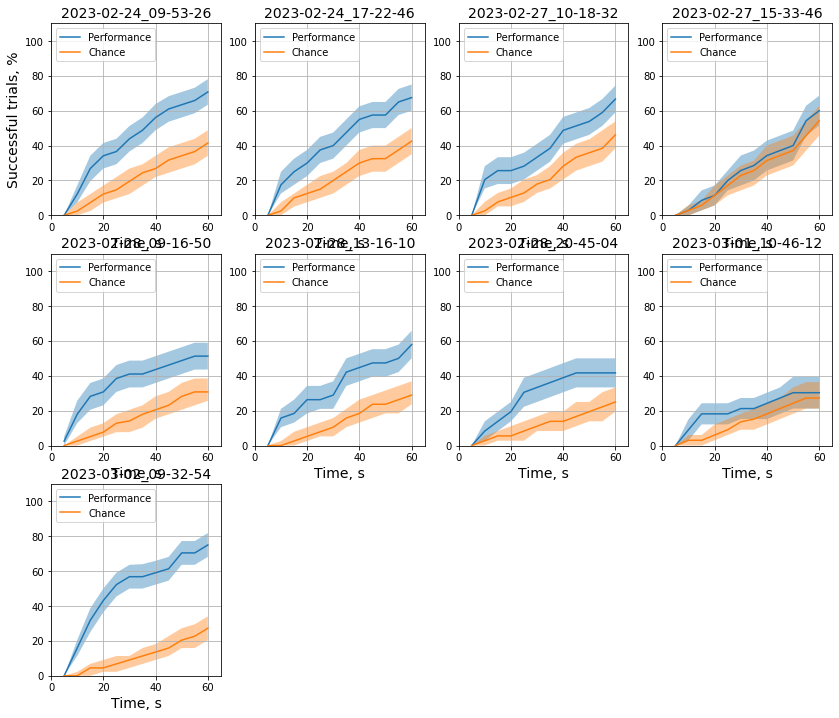

In [17]:
selected = sessions

fig = plt.figure(figsize=(3.5 * n_cols, 4 * n_rows))

for i, session in enumerate(selected):
    h5name = os.path.join(source, animal, session, session + '.h5')
    with h5py.File(h5name, 'r') as f:
        perf = np.array(f['analysis']['performance_ALL'])
        x = perf[:, 6]
        
    ax = fig.add_subplot(n_rows, n_cols, i+1)

    ax.plot(x, perf[:, 0], label='Performance')  # performance
    ax.plot(x, perf[:, 3], label='Chance')  # chance
    ax.fill_between(x, perf[:, 0] + perf[:, 1], perf[:, 0] + perf[:, 2], alpha=0.4)
    ax.fill_between(x, perf[:, 3] + perf[:, 4], perf[:, 3] + perf[:, 5], alpha=0.4)
    ax.set_ylim(0, 110)
    ax.set_xlim(0, 65)
    ax.grid()
    ax.set_title(session[-19:], fontsize=14)
    ax.set_xlabel('Time, s', fontsize=14)
    ax.legend(loc='upper left')
    
    if i == 0:
        ax.set_ylabel('Successful trials, %', fontsize=14)
        
fig.tight_layout()

## Separate periods

In [ ]:
names = ['ALL', 'L', 'D', 'Lp']
performances = []
with h5py.File(h5name, 'r') as f:
    for name in names:
        performances.append( np.array(f['analysis']['performance_%s' % name]) )

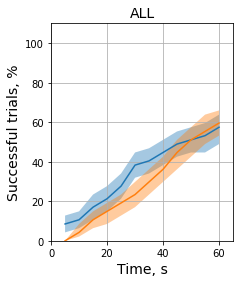

In [13]:
fig = plt.figure(figsize=(15,4))

for i, name in enumerate(names):
    ax = fig.add_subplot(1, 4, i+1)

    perf = performances[i]
    x = perf[:, 6]
    
    ax.plot(x, perf[:, 0])  # performance
    ax.plot(x, perf[:, 3])  # chance
    ax.fill_between(x, perf[:, 0] + perf[:, 1], perf[:, 0] + perf[:, 2], alpha=0.4)
    ax.fill_between(x, perf[:, 3] + perf[:, 4], perf[:, 3] + perf[:, 5], alpha=0.4)
    ax.set_ylim(0, 110)
    ax.set_xlim(0, 65)
    ax.grid()
    ax.set_title(name, fontsize=14)
    ax.set_xlabel('Time, s', fontsize=14)
    
    if i == 0:
        ax.set_ylabel('Successful trials, %', fontsize=14)

## Reward performance in light vs dark

In [5]:
def reward_counts_in_light_and_dark(source, animal, session):
    s_path = os.path.join(source, animal, session)
    h5name = os.path.join(s_path, session + '.h5')
    jsname = os.path.join(s_path, session + '.json')
    
    # loading session configuration
    with open(jsname, 'r') as f:
        cfg = json.load(f)

    # loading position and trial data
    with h5py.File(h5name, 'r') as f:
        tl = np.array(f['processed']['timeline'])  # time, X, Y, speed
        trial_idxs = np.array(f['processed']['trial_idxs']) # idx start, idx end, X, Y, R, trial result (idx to tl)

    s_duration = cfg['experiment']['session_duration']
    timepoints = cfg['experiment']['timepoints']
    l_periods = [[0, timepoints[0]], [timepoints[3], s_duration]]
    d_periods = [[timepoints[0], timepoints[3]]]
    trial_starts = tl[trial_idxs[:, 0].astype(np.int32)][:, 0]
    trial_ends   = tl[trial_idxs[:, 1].astype(np.int32)][:, 0]

    def get_reward_count(periods):
        rewards  = 0
        duration = 0
        for t_start, t_end in periods:
            tr_idxs = trial_idxs[(trial_starts >= t_start) & (trial_ends <= t_end)]
            rewards  += len(tr_idxs[tr_idxs[:, 5] == 1])
            duration += t_end - t_start
        return rewards, duration

    return np.array([get_reward_count(l_periods), get_reward_count(d_periods)])

In [6]:
# session paths
source = '/home/sobolev/nevermind/Andrey/data'
animal = '006865'

# single sessions
sessions = ['006865_hippoSIT_2021-12-17_15-14-51']

# or list of sessions
sessions = get_sessions_list(os.path.join(source, animal), animal)

In [7]:
all_stats = []
for session in sessions:
    all_stats.append( reward_counts_in_light_and_dark(source, animal, session) )

Text(0.5, 1.0, 'Animal #006865')

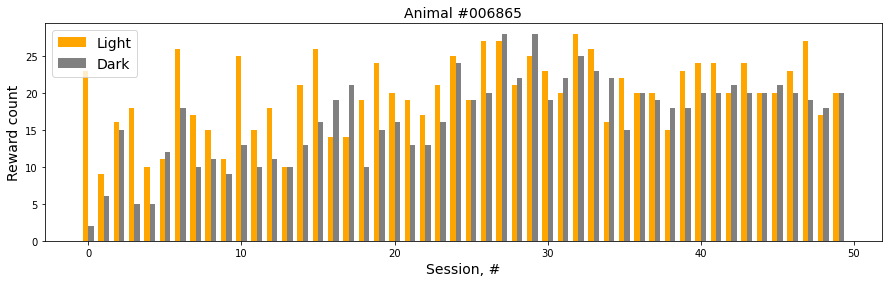

In [8]:
# for 006865 sessions before 9 are not in dark
idx = 9
labels = sessions[idx:]
rewards_l = np.array([x[0][0] for x in all_stats[idx:]])
rewards_d = np.array([x[1][0] for x in all_stats[idx:]])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1, 1, 1)

rects1 = ax.bar(x - width/2, rewards_l, width, label='Light', color='orange')
rects2 = ax.bar(x + width/2, rewards_d, width, label='Dark', color='gray')
ax.legend(fontsize=14)
ax.set_xlabel('Session, #', fontsize=14)
ax.set_ylabel('Reward count', fontsize=14)
ax.set_title('Animal #%s' % animal, fontsize=14)

Text(0, 0.5, 'Reward count, %')

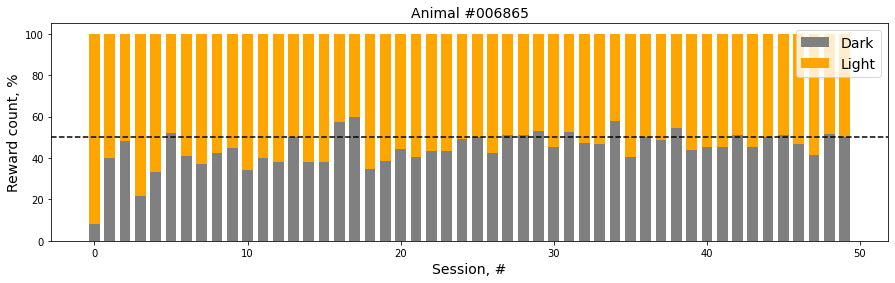

In [12]:
# for 006865 sessions before 9 are not in dark
idx = 9
labels = sessions[idx:]
rewards_l = np.array([x[0][0] for x in all_stats[idx:]])
rewards_d = np.array([x[1][0] for x in all_stats[idx:]])
rew_total = rewards_l + rewards_d

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1, 1, 1)

rects1 = ax.bar(x, 100*rewards_d/rew_total, width, label='Dark', color='gray')
rects2 = ax.bar(x, 100*rewards_l/rew_total, width, bottom=100*rewards_d/rew_total, label='Light', color='orange')
ax.axhline(50, color='black', ls='--')
ax.legend(fontsize=14)
ax.set_title('Animal #%s' % animal, fontsize=14)
ax.set_xlabel('Session, #', fontsize=14)
ax.set_ylabel('Reward count, %', fontsize=14)

### special plot for grant application

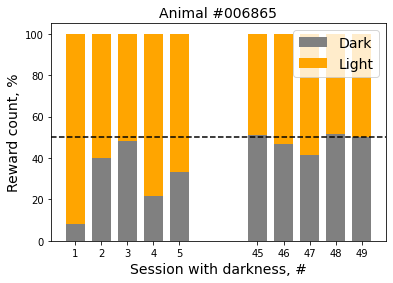

In [27]:
rew_l_ = np.concatenate([rewards_l[:5], rewards_l[-5:]])
rew_d_ = np.concatenate([rewards_d[:5], rewards_d[-5:]])
rew_t_ = np.concatenate([rew_total[:5], rew_total[-5:]])

x = np.concatenate([np.arange(5) + 1, np.arange(5) + 8])
x_tick_ls = np.concatenate([np.arange(5) + 1, np.arange(5) + len(rew_total) - 5])
width = 0.7  # the width of the bars

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 1, 1)

rects1 = ax.bar(x, 100*rew_d_/rew_t_, width, label='Dark', color='gray')
rects2 = ax.bar(x, 100*rew_l_/rew_t_, width, bottom=100*rew_d_/rew_t_, label='Light', color='orange')
ax.axhline(50, color='black', ls='--')
ax.legend(fontsize=14, loc='upper right')
ax.set_title('Animal #%s' % animal, fontsize=14)
ax.set_xlabel('Session with darkness, #', fontsize=14)
ax.set_ylabel('Reward count, %', fontsize=14)
ax.set_xticks(x)
_ = ax.set_xticklabels(x_tick_ls)

## Trial performance

In [7]:
# session paths
source = '/home/sobolev/nevermind/Andrey/data'
animal = '009266'

# or list of sessions
sessions = get_sessions_list(os.path.join(source, animal), animal)

In [123]:
session = sessions[0]
s_path = os.path.join(source, animal, session)
h5name = os.path.join(s_path, session + '.h5')
jsname = os.path.join(s_path, session + '.json')

# loading session configuration
with open(jsname, 'r') as f:
    cfg = json.load(f)

with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed
    trial_idxs = np.array(f['processed']['trial_idxs']) # idx start, idx end, X, Y, R, trial result (idx to tl)

Text(0.5, 1.0, '#006618, session 2022-11-17')

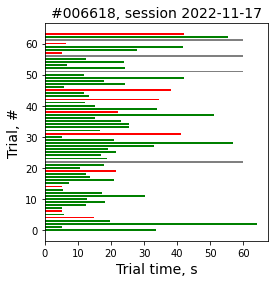

In [124]:
timepoints = cfg['experiment']['timepoints']
durations = tl[trial_idxs[:, 1].astype(int)][:, 0] - tl[trial_idxs[:, 0].astype(int)][:, 0]
failed_idxs   = np.where(trial_idxs[:, 5] == 0)[0]
not_none_idxs = np.where(durations < 59)[0]
distrac_idxs  = list(np.intersect1d(failed_idxs, not_none_idxs))

_colors = ['green' if x == 1 else 'grey' for x in trial_idxs[:, 5]]
colors  = [_colors[i] if not i in distrac_idxs else 'red' for i in range(len(_colors))]

t_dark_beg = timepoints[0]
t_dark_end = timepoints[-1]
trial_starts = tl[trial_idxs[:, 0].astype(int)][:, 0]

idx_dark_beg = len(trial_starts[trial_starts < t_dark_beg])
idx_dark_end = len(trial_starts[trial_starts < t_dark_end])

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.barh(np.arange(len(trial_idxs)), durations, height=0.6, color=colors, align='center')
ax.set_xlabel('Trial time, s', fontsize=14)
ax.set_ylabel('Trial, #', fontsize=14)
ax.set_title('#%s, session %s' % (animal, session[16:26]), fontsize=14)
#ax.legend(fontsize=14, loc='lower right')
#ax.axhspan(idx_dark_beg, idx_dark_end, facecolor='grey', alpha=0.3)

## Miltiple island performance

In [125]:
source = '/home/sobolev/nevermind/Andrey/data'
animal = '006618'

# single sessions
sessions = ['008229_hippoSIT_2022-06-09_14-15-49']

# or list of sessions
sessions = get_sessions_list(os.path.join(source, animal), animal)[-5:]
sessions

['006618_hippoSIT_2022-11-17_14-42-54', '006618_hippoSIT_2022-11-18_13-47-44']

In [126]:
session = sessions[0]
s_path = os.path.join(source, animal, session)
h5name = os.path.join(s_path, session + '.h5')

with h5py.File(h5name, 'r') as f:
    cfg = json.loads(f['processed'].attrs['parameters'])
    performance_matrix = np.array(f['analysis']['performance_ALL'])
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed
    trial_idxs = np.array(f['processed']['trial_idxs']) # idx start, idx end, X, Y, R, trial result (idx to tl)

In [127]:
durations = tl[trial_idxs[:, 1].astype(int)][:, 0] - tl[trial_idxs[:, 0].astype(int)][:, 0]

# successful trials
success_idxs = np.where(trial_idxs[:, 5] == 1)[0]

# distractor trials
failed_idxs   = np.where(trial_idxs[:, 5] == 0)[0]
not_none_idxs = np.where(durations < 59)[0]
distrac_idxs  = np.intersect1d(failed_idxs, not_none_idxs)

# None trials
none_idxs = np.where(durations > 59)[0]
none_idxs = np.intersect1d(failed_idxs, none_idxs)

perf_level, chance_level = performance_matrix[-1][0], performance_matrix[-1][3]

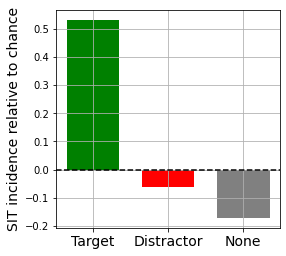

In [128]:
results = [
    len(success_idxs) / len(trial_idxs) - chance_level/100.0,
    len(distrac_idxs) / len(trial_idxs) - chance_level/100.0,
    len(none_idxs) / len(trial_idxs) - chance_level/100.0
]

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)

rects1 = ax.bar([1, 2, 3], results, 0.7, label='Dark', color=['green', 'red', 'gray'])
ax.grid()
ax.set_ylabel('SIT incidence relative to chance', fontsize=14)
ax.set_xticks([1, 2, 3])
_ = ax.set_xticklabels(['Target', 'Distractor', 'None'], fontsize=14)
ax.axhline(0, ls='--', color='black')

## Pie percentage target / distractors

In [12]:
session = sessions[0]

finish_times = get_finish_times(os.path.join(source, animal, session))
island_succ_rates = get_finish_times_rates(finish_times)

ValueError: cannot reshape array of size 6 into shape (3,3)

In [8]:
finish_times[:5], island_succ_rates

(array([[  0.  ,   0.  ,   0.  ],
        [  0.  , 120.95,   0.  ],
        [177.77,   0.  ,   0.  ],
        [  0.  ,   0.  , 212.07],
        [297.9 ,   0.  ,   0.  ]]),
 array([22., 12., 11.,  5.]))

(-1.1254831920242543,
 1.1208439095380611,
 -1.1339686285189259,
 1.2316379554116026)

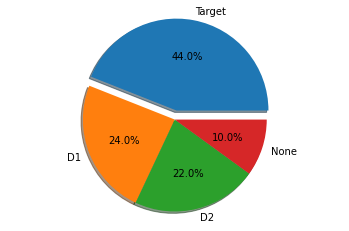

In [15]:
import matplotlib.pyplot as plt

labels  = ['D%s' % str(x + 1) for x in range(len(island_succ_rates) - 2)]
labels  = ['Target'] + labels + ['None']
sizes   = island_succ_rates
explode = [0.1] + [0 for x in range(len(island_succ_rates) - 1)]  # only "explode" the target

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

Text(0, 0.5, 'Correct islands')

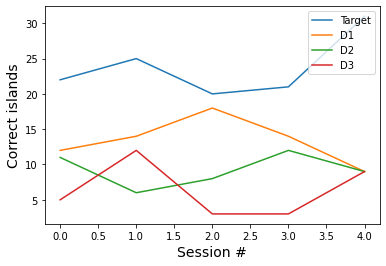

In [41]:
import matplotlib.pyplot as plt

all_rates = []
for session in sessions:
    finish_times = get_finish_times(os.path.join(source, animal, session))
    island_succ_rates = get_finish_times_rates(finish_times)    

    all_rates.append(island_succ_rates)
    
labels  = ['D%s' % str(x + 1) for x in range(len(all_rates) - 2)]
labels  = ['Target'] + labels + ['None']

fig, ax = plt.subplots()
for i, rates in enumerate(np.array(all_rates).T):
    ax.plot(rates, label=labels[i])
    
ax.legend(loc='upper right')
ax.set_xlabel('Session #', fontsize=14)
ax.set_ylabel('Correct islands', fontsize=14)

## Simple Trial Performance 

In [4]:
source = '/home/sobolev/nevermind/Andrey/data'
animal = '009265'

# or list of sessions
sessions = get_sessions_list(os.path.join(source, animal), animal)#[-5:]
sessions[:5]

['009265_hippoSIT_2023-02-21_20-44-17',
 '009265_hippoSIT_2023-02-22_08-50-47',
 '009265_hippoSIT_2023-02-22_15-22-30',
 '009265_hippoSIT_2023-02-23_09-08-17',
 '009265_hippoSIT_2023-02-23_15-24-36']

In [8]:
success_rates = {}

rates = np.zeros(len(sessions))
for i, session in enumerate(sessions):
    s_path = os.path.join(source, animal, session)
    h5name = os.path.join(s_path, session + '.h5')

    with h5py.File(h5name, 'r') as f:
        #cfg = json.loads(f['processed'].attrs['parameters'])
        #tl = np.array(f['processed']['timeline'])  # time, X, Y, speed
        if not 'processed' in f:
            continue
        trial_idxs = np.array(f['processed']['trial_idxs']) # idx start, idx end, X, Y, R, trial result (idx to tl)

    succ_rate = trial_idxs[:, 5].sum() / len(trial_idxs)
    success_rates[session] = succ_rate
    rates[i] = succ_rate

In [11]:
[round(x, 2) for x in list(rates)]

[0.69,
 0.52,
 0.41,
 0.46,
 0.53,
 0.73,
 0.72,
 0.72,
 0.57,
 0.51,
 0.58,
 0.44,
 0.33,
 0.75,
 0.38,
 0.59,
 0.73,
 0.71,
 0.74,
 0.8,
 0.82,
 0.78,
 0.58,
 0.46,
 0.49,
 0.77]

In [27]:
s_types = {}
for session in sessions:
    s_path = os.path.join(source, animal, session)
    h5name = os.path.join(s_path, session + '.h5')

    with h5py.File(h5name, 'r') as f:
        cfg = json.loads(f['processed'].attrs['parameters'])
        
    cfg_bgr = cfg['sound']['sounds']['background']
    cfg_tgt = cfg['sound']['sounds']['target']
    
    s_type = ''
    if cfg_bgr['freq'] != cfg_tgt['freq']:
        s_type += 'F'
    if cfg_bgr['amp'] != cfg_tgt['amp']:
        s_type += 'A'
    if cfg_bgr['duration'] != cfg_tgt['duration']:
        s_type += 'D'
    if s_type == '':
        s_type = 'L'
    s_types[session] = s_type
    
list(s_types.values())

['A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'A',
 'L',
 'L',
 'L',
 'F',
 'F',
 'F',
 'F',
 'F',
 'FD',
 'F',
 'D',
 'D',
 'A',
 'A',
 'F',
 'F',
 'D',
 'D',
 'D',
 'FA',
 'A',
 'D',
 'F',
 'F',
 'F',
 'D',
 'D',
 'D',
 'D',
 'D',
 'F',
 'F',
 'F',
 'D',
 'F',
 'F',
 'F',
 'D',
 'F']